In [1]:
import shap
import torch
import pandas as pd
from set_transformer.set_transformer_architecture import SetTransformer, SetTransformerWrapper


model_name = "SetTransformer"
phenotype = "ogt"
ind_point = 10
D = 3165
K = 1
dim_output = 80
save_path = f"set_transformer/resuls_SetTransformer/trained_models/trained_model_{model_name}_phenotype_{phenotype}_indPoints_{ind_point}_D_{D}_K_{K}_dim_output_{dim_output}.model" 

loaded_model = SetTransformer(D, K, dim_output)

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load(save_path, weights_only=True))


<All keys matched successfully>

In [2]:
output_class = 0  # Specify the class index you want to explain
wrapped_model = SetTransformerWrapper(loaded_model, output_class)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapped_model = wrapped_model.to(device)

In [4]:
from set_transformer.main import read_ogt_data

if phenotype == "ogt":
    X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, num_classes = read_ogt_data()
print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")

print(f"X_train[:10].unsqueeze(1).shape = {X_train[:100].unsqueeze(1).shape}")


X_train = X_train.to(device)
X_test = X_test.to(device)

X_train.shape = torch.Size([3001, 3165])
X_test.shape = torch.Size([751, 3165])
X_train[:10].unsqueeze(1).shape = torch.Size([100, 1, 3165])


In [6]:
modal_keggs = pd.read_csv('data_aerob/modal_keggs_with_names.csv',sep="\t")
modal_keggs.index = modal_keggs['ko']
 
columns2 = pd.Series(['{} {} {}'.format(cog, ko, ko_name) for cog, ko, ko_name in zip(modal_keggs.loc[X_test_column_names,'ko'], modal_keggs.loc[X_test_column_names,'cog'], modal_keggs.loc[X_test_column_names,'ko_name'])])
dup_columns = columns2.duplicated()
columns2 = ["{}_{}".format(c,i) if is_dup else c for c,i,is_dup in zip(columns2, range(len(columns2)), dup_columns)]
kos_and_names_column_names = [c.replace('[', '').replace(']', '').replace('<', '_') for c in columns2]


In [13]:
explainer = shap.DeepExplainer(wrapped_model, X_train.unsqueeze(1))
shap_values = explainer.shap_values(X_test.unsqueeze(1), check_additivity=False)

shap_values = shap_values.squeeze(1)

print(f"Shape of shap_values: {shap_values.shape}")

# For visualization, you can extract SHAP values for a specific class if needed
shap_values_class_0 = shap_values[:, :, 0]  # For class 0 (first class)
print(f"Shape of shap_values_class_0: {shap_values_class_0.shape}")

C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')


Shape of shap_values: (751, 3165, 80)
Shape of shap_values_class_0: (751, 3165)


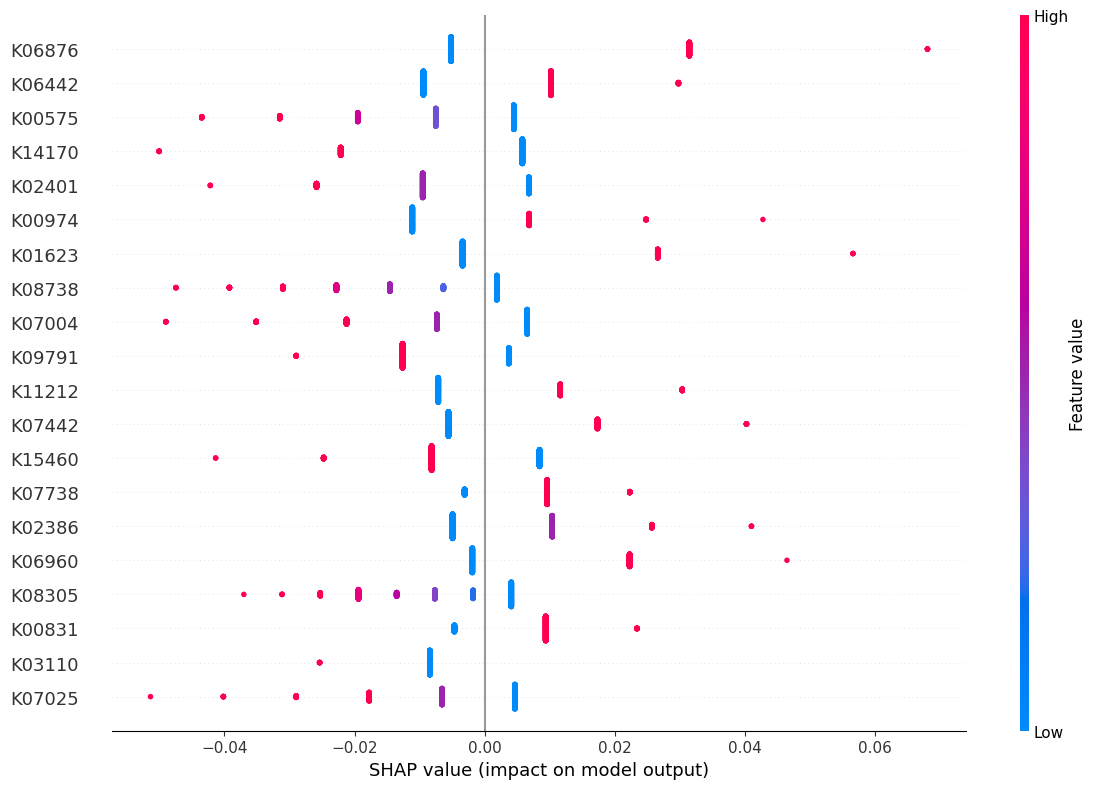

In [14]:
#shap_values_class_0 = shap_values[:, :, 0]

shap.summary_plot(shap_values_class_0, X_test.cpu().numpy(), max_display=20, feature_names=X_test_column_names, plot_size=(12, 8))
#plt.show()

In [15]:
import numpy as np

mean_abs_shap_values = np.abs(shap_values_class_0).mean(axis=0)
top_20_indices = np.argsort(mean_abs_shap_values)[-20:][::-1]
top_20_features = [(kos_and_names_column_names[i], mean_abs_shap_values[i]) for i in top_20_indices]

print("Top 20 features with the highest SHAP values:\n")
for feature_name, shap_value in top_20_features:
    print(f"{feature_name}: {shap_value:.4f}")

Top 20 features with the highest SHAP values:

K01174 COG1525 micrococcal nuclease EC:3.1.31.1: 0.0150
K16785 COG0619 energy-coupling factor transport system permease protein: 0.0103
K07729 COG1476 putative transcriptional regulator: 0.0103
K09719 COG1689 uncharacterized protein: 0.0103
K00057 COG0240 glycerol-3-phosphate dehydrogenase (NAD(P)+) EC:1.1.1.94: 0.0101
K09900 COG3097 N4-acetylcytidine amidohydrolase EC:3.5.1.135: 0.0101
K16168 COG1755 methyltransferase: 0.0096
K02232 COG1492 adenosylcobyric acid synthase EC:6.3.5.10: 0.0096
K09792 COG2836 uncharacterized protein: 0.0095
K07063 COG1569 uncharacterized protein: 0.0095
K03187 COG2371 urease accessory protein: 0.0095
K01447 COG3023 N-acetylmuramoyl-L-alanine amidase EC:3.5.1.28: 0.0093
K02348 COG2153 ElaA protein: 0.0090
K01624 COG0191 fructose-bisphosphate aldolase, class II EC:4.1.2.13: 0.0089
K20528 COG3838 type IV secretion system protein TrbC: 0.0088
K02420 COG1987 flagellar biosynthesis protein FliQ: 0.0088
K05803 COG478

In [16]:
model_name = "SetTransformer"
phenotype = "aerob"
ind_point = 10
D = 2677
K = 1
dim_output = 1
save_path = f"set_transformer/resuls_SetTransformer/trained_models/trained_model_{model_name}_phenotype_{phenotype}_indPoints_{ind_point}_D_{D}_K_{K}_dim_output_{dim_output}.model" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_model_aerob = SetTransformer(D, K, dim_output)

# Load the saved state dictionary
loaded_model_aerob.load_state_dict(torch.load(save_path, weights_only=True))

<All keys matched successfully>

In [17]:
from set_transformer.main import process_dataset

data_filename_train = 'data_aerob/all_gene_annotations.added_incompleteness_and_contamination.subsampled.training.tsv' 
data_filename_test = 'data_aerob/all_gene_annotations.added_incompleteness_and_contamination.subsampled.testing.tsv'
y_filename = 'data_aerob/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv'

if phenotype == "aerob":
    X_train, X_train_column_names, y_train, d_gtdb_train = process_dataset(data_filename_train, y_filename)
    X_test, X_test_column_names, y_test, d_gtdb_test = process_dataset(data_filename_test, y_filename)
    num_classes = 2

print(X_train.shape)    
print(X_test.shape)    

Counts of each class in training/test data: shape: (2, 2)
┌──────────────┬───────┐
│ oxytolerance ┆ len   │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ anaerobe     ┆ 29808 │
│ aerobe       ┆ 29808 │
└──────────────┴───────┘


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
modal_keggs = pd.read_csv('data_aerob/modal_keggs_with_names.csv',sep="\t")
modal_keggs.index = modal_keggs['cog']
 
columns2 = pd.Series(['{} {} {}'.format(cog, ko, ko_name) for cog, ko, ko_name in zip(modal_keggs.loc[X_test_column_names,'cog'], modal_keggs.loc[X_test_column_names,'ko'], modal_keggs.loc[X_test_column_names,'ko_name'])])
dup_columns = columns2.duplicated()
columns2 = ["{}_{}".format(c,i) if is_dup else c for c,i,is_dup in zip(columns2, range(len(columns2)), dup_columns)]
kos_and_names_column_names = [c.replace('[', '').replace(']', '').replace('<', '_') for c in columns2]

In [ ]:
explainer = shap.DeepExplainer(loaded_model_aerob, X_train.unsqueeze(1))
shap_values = explainer.shap_values(X_test.unsqueeze(1), check_additivity=False)

shap_values = shap_values.squeeze(1)

print(f"Shape of shap_values: {shap_values.shape}")
print(f"Shape of X_test[:1000]: {X_test.shape}")

# For visualization, you can extract SHAP values for a specific class if needed
shap_values_class_0 = shap_values[:, :, 0]  # For class 0 (first class)
print(f"Shape of shap_values_class_0: {shap_values_class_0.shape}")

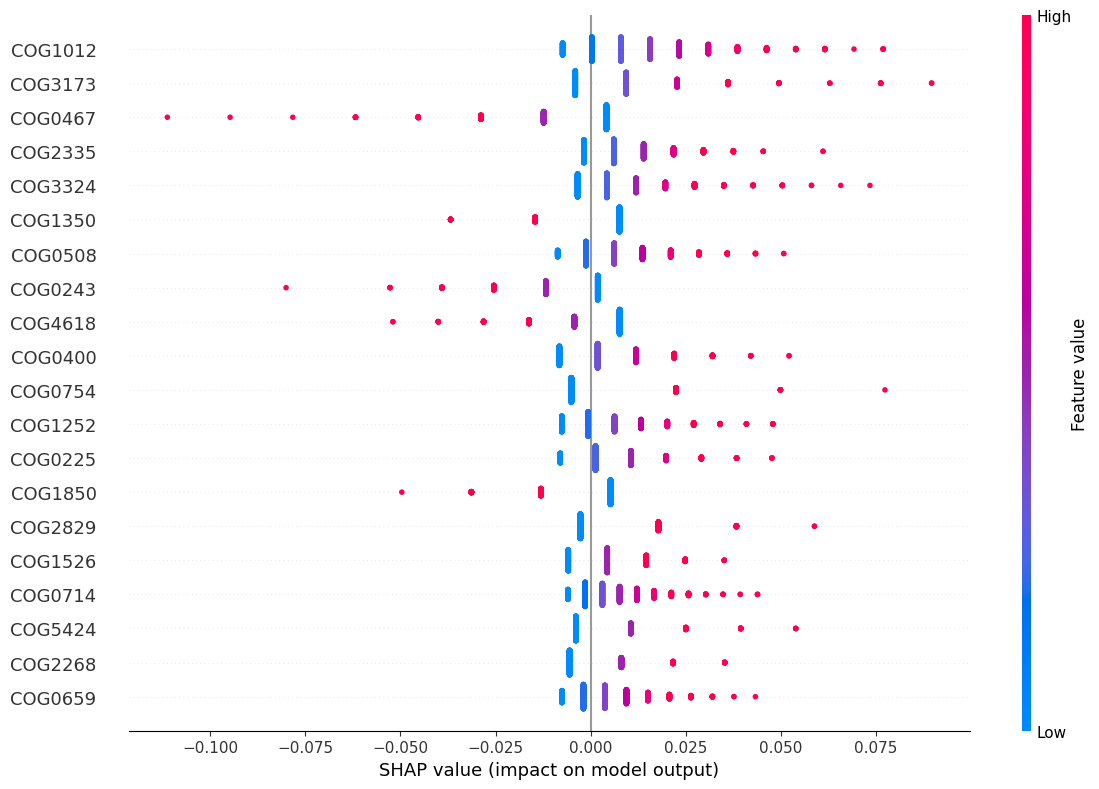

In [62]:
shap.summary_plot(shap_values_class_0, X_test.cpu().numpy(), max_display=20, feature_names=X_test_column_names, plot_size=(12, 8))

In [57]:
import numpy as np

mean_abs_shap_values = np.abs(shap_values_class_0).mean(axis=0)
top_20_indices = np.argsort(mean_abs_shap_values)[-20:][::-1]
top_20_features = [(kos_and_names_column_names[i], mean_abs_shap_values[i]) for i in top_20_indices]

print("Top 20 features with the highest SHAP values:\n")
for feature_name, shap_value in top_20_features:
    print(f"{feature_name}: {shap_value:.4f}")

Top 20 features with the highest SHAP values:

COG1012 K00135 succinate-semialdehyde dehydrogenase / glutarate-semialdehyde dehydrogenase EC:1.2.1.16 1.2.1.79 1.2.1.20: 0.0150
COG3173 K11729 acyl-CoA dehydrogenase family member 10: 0.0114
COG0467 K08482 circadian clock protein KaiC: 0.0103
COG2335 K19519 transforming growth factor-beta-induced protein: 0.0097
COG3324 K06996 uncharacterized protein: 0.0094
COG1350 K06001 tryptophan synthase beta chain EC:4.2.1.20: 0.0093
COG0508 K00627 pyruvate dehydrogenase E2 component (dihydrolipoamide acetyltransferase) EC:2.3.1.12: 0.0090
COG0243 K08352 thiosulfate reductase / polysulfide reductase chain A EC:1.8.5.5: 0.0085
COG4618 K12536 ATP-binding cassette, subfamily C, type I secretion system permease/ATPase: 0.0084
COG0400 K06999 phospholipase/carboxylesterase: 0.0084
COG0754 K01460 glutathionylspermidine amidase/synthetase EC:3.5.1.78 6.3.1.8: 0.0082
COG1252 K03885 NADH:quinone reductase (non-electrogenic) EC:1.6.5.9: 0.0082
COG0225 K07304 p